# College Yield Prediction: EDA & Deep Learning Model

This notebook performs Exploratory Data Analysis (EDA) on the college admissions data and trains a Deep Learning model to predict yield rates.

In [11]:
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Data Loading

In [12]:
with open("../data/data.yaml", "r") as f:
    config = yaml.safe_load(f)

# Define Features from Scorecard (X)
scorecard_features_map = {
    'school_name': 'school.name',
    'state': 'school.state',
    'control': 'school.ownership',           # 1=Public, 2=Private
    'tuition_in_state': 'cost.tuition.in_state',
    'sat_avg': 'admissions.sat_scores.average.overall',
    'pell_grant_rate': 'aid.pell_grant_rate',
    'faculty_salary': 'school.faculty_salary',
    'unitid': 'id'                           # CRITICAL: Join Key
}

# Extract raw CSV column names from YAML
use_cols_scorecard = {}
for alias, yaml_key in scorecard_features_map.items():
    if yaml_key in config['dictionary']:
        raw_col = config['dictionary'][yaml_key]['source']
        use_cols_scorecard[raw_col] = alias

# Load College Scorecard
df_sc = pd.read_csv(
    "../data/MERGED2023_24_PP.csv", 
    usecols=use_cols_scorecard.keys(), 
    na_values=config['null_value']
)
df_sc.rename(columns=use_cols_scorecard, inplace=True)

# Load IPEDS Admissions Data (For Target)
df_ipeds = pd.read_csv("../data/ADM2024.csv")
df_ipeds = df_ipeds[['UNITID', 'ADMSSN', 'ENRLT']]

# Inner join: We only want schools that appear in BOTH datasets
df_final = pd.merge(df_sc, df_ipeds, left_on='unitid', right_on='UNITID', how='inner')

# Calculate Yield: Enrolled / Admitted
df_final['YIELD'] = df_final['ENRLT'] / df_final['ADMSSN']

# Data Cleaning
df_final = df_final[df_final['ADMSSN'] > 0]   # Avoid divide by zero
df_final = df_final[df_final['YIELD'] <= 1.0] # Remove invalid data (Yield > 100%)
df_final = df_final.dropna(subset=['YIELD'])  # Drop missing targets

print(f"Dataset Shape: {df_final.shape}")
df_final.head()

Dataset Shape: (1917, 12)


,unitid,school_name,state,control,sat_avg,tuition_in_state,faculty_salary,pell_grant_rate,UNITID,ADMSSN,ENRLT,YIELD
0,100654,Alabama A & M University,AL,1,947.0,10024.0,8610.0,0.6441,100654,13564.0,1968.0,0.145090
1,100663,University of Alabama at Birmingham,AL,1,1251.0,8832.0,12211.0,0.3318,100663,10034.0,2014.0,0.200718
2,100706,University of Alabama in Huntsville,AL,1,1321.0,11770.0,10411.0,0.2250,100706,5232.0,1212.0,0.231651
3,100724,Alabama State University,AL,1,977.0,11248.0,8015.0,0.7203,100724,7052.0,1056.0,0.149745
4,100751,The University of Alabama,AL,1,1287.0,11900.0,11090.0,0.1799,100751,43531.0,8032.0,0.184512


## 2. Exploratory Data Analysis (EDA)

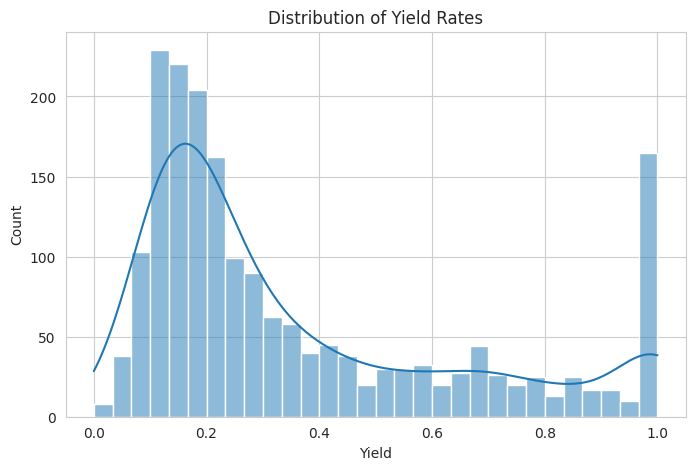

In [13]:
# Distribution of Yield
plt.figure(figsize=(8, 5))
sns.histplot(df_final['YIELD'], bins=30, kde=True)
plt.title('Distribution of Yield Rates')
plt.xlabel('Yield')
plt.show()

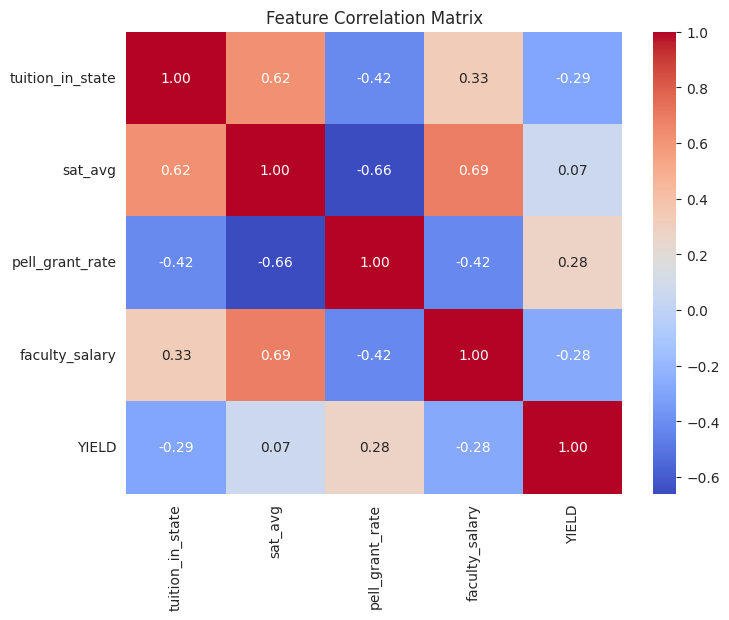

In [14]:
# Correlation Matrix
numeric_features = ['tuition_in_state', 'sat_avg', 'pell_grant_rate', 'faculty_salary', 'YIELD']
corr = df_final[numeric_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

/tmp/ipykernel_5976/61742389.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


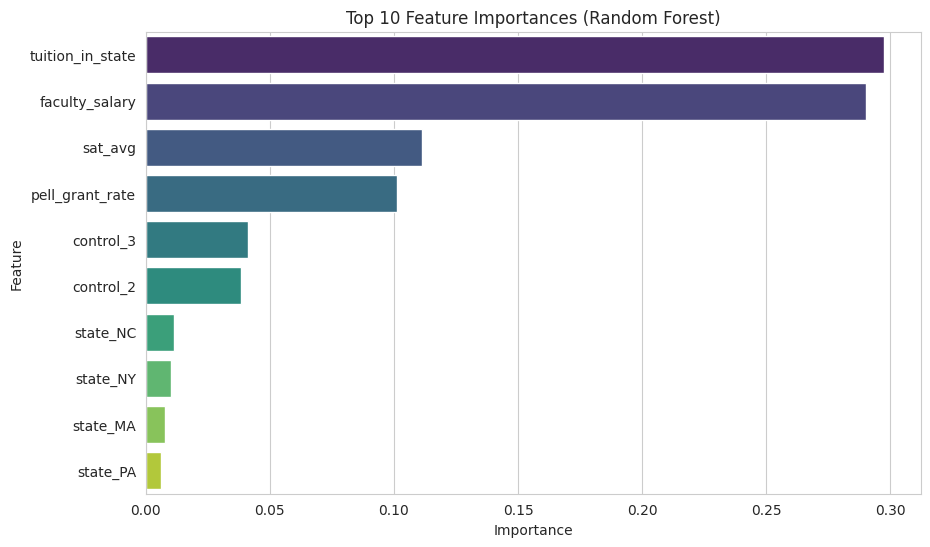

In [15]:
# Feature Importance using Random Forest
features = ['tuition_in_state', 'sat_avg', 'pell_grant_rate', 'faculty_salary', 'control', 'state']
# Simple preprocessing for RF
X_rf = df_final[features].copy()
y_rf = df_final['YIELD']

# Handle categorical for basic importance check (OneHotEncode manually or categorical codes)
X_rf = pd.get_dummies(X_rf, columns=['state', 'control'], drop_first=True)
X_rf = X_rf.fillna(X_rf.median())

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_rf, y_rf)

importances = pd.DataFrame({'Feature': X_rf.columns, 'Importance': rf.feature_importances_})
top_features = importances.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

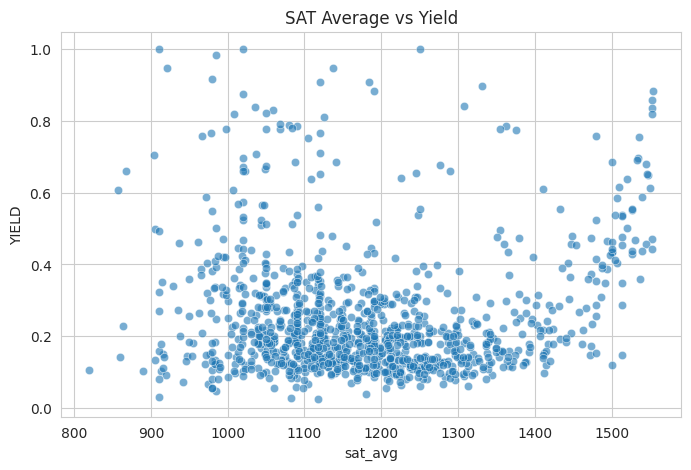

In [16]:
# Visualizing Top Features vs Yield
if 'sat_avg' in df_final.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='sat_avg', y='YIELD', data=df_final, alpha=0.6)
    plt.title('SAT Average vs Yield')
    plt.show()

## 3. Deep Learning Model

In [17]:
# Preprocessing
numeric_features = ['tuition_in_state', 'sat_avg', 'pell_grant_rate', 'faculty_salary']
categorical_features = ['state', 'control']

X = df_final[numeric_features + categorical_features]
y = df_final['YIELD']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert sparse matrices to dense arrays for TensorFlow
if hasattr(X_train_processed, 'toarray'):
    X_train_processed = X_train_processed.toarray()
    X_test_processed = X_test_processed.toarray()

print(f"Training Input Shape: {X_train_processed.shape}")

Training Input Shape: (1533, 62)


In [18]:
# Define Model Architecture
def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid') # Yield is 0-1
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae']) # Using MSE for regression
    return model

model = build_model(X_train_processed.shape[1])
model.summary()

/app/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,201 (75.00 KB)

 Trainable params: 18,817 (73.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [19]:
# Train Model
history = model.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0867 - mae: 0.2279 - val_loss: 0.0738 - val_mae: 0.2406
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0611 - mae: 0.1813 - val_loss: 0.0674 - val_mae: 0.2265
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0548 - mae: 0.1714 - val_loss: 0.0616 - val_mae: 0.2115
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0520 - mae: 0.1666 - val_loss: 0.0583 - val_mae: 0.2026
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0497 - mae: 0.1632 - val_loss: 0.0547 - val_mae: 0.1935
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0433 - mae: 0.1545 - val_loss: 0.0491 - val_mae: 0.1774
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0461 - mae: 0.1575 - val_loss: 0.0447 - val_mae: 0.1618
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0417 - mae: 0.1485 - val_loss: 0.0422 - val_mae: 0.1545
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0425 - mae: 

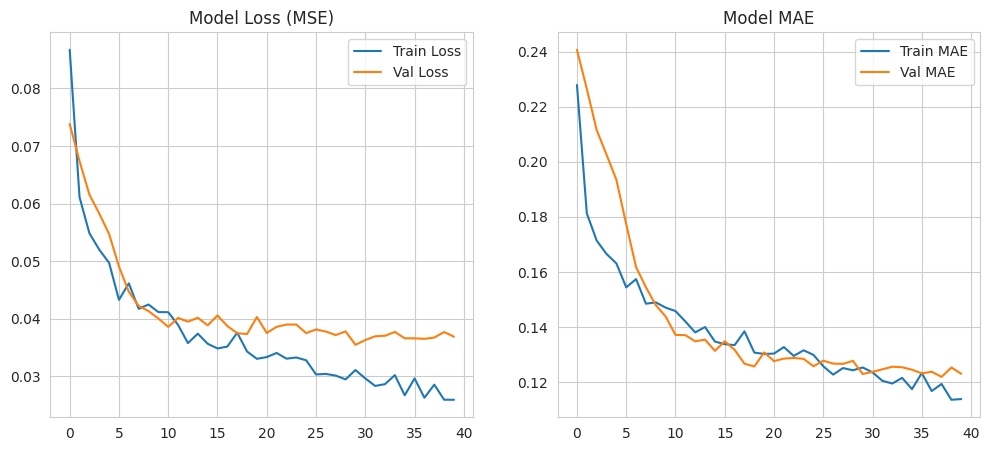

In [20]:
# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.legend()
plt.show()

## 4. Evaluation

Test MAE: 0.1301
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


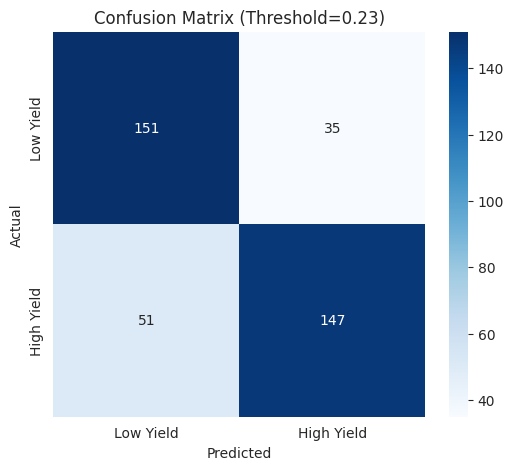

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       186
           1       0.81      0.74      0.77       198

    accuracy                           0.78       384
   macro avg       0.78      0.78      0.78       384
weighted avg       0.78      0.78      0.78       384



In [21]:
# Evaluate on Test Data
test_loss, test_mae = model.evaluate(X_test_processed, y_test, verbose=0)
print(f"Test MAE: {test_mae:.4f}")

# Predictions
y_pred = model.predict(X_test_processed).flatten()

# Binarize predictions for Confusion Matrix (Threshold = 0.5 or Median)
threshold = y_train.median()
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred > threshold).astype(int)

cm = confusion_matrix(y_test_binary, y_pred_binary)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Yield', 'High Yield'], yticklabels=['Low Yield', 'High Yield'])
plt.title(f'Confusion Matrix (Threshold={threshold:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_test_binary, y_pred_binary))